<a href="https://colab.research.google.com/github/n-gregori/Deeplearning_lecture_training_workshop/blob/master/deeplearning_training_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?id=1h3jKvuTaKgkvE4_BwdSK62ieVZFEqeNC)

<a id='start'></a>
#Deeplearning workshop

## Overview


The workshop is composed by the following sections:<br>
- [Introduction](#section1)
- [Setting up the environment](#section2)
- [Data exploration](#section3.1)
- [Dealing with imbalance problems](#section3.2)
- [Data ingestion pipeline](#section3.3)
- [Create your own NN](#section4.1)
- [Model result evaluation](#section4.2)
-[The importance of the weights initialization](#section4.3)
- [Handling overfitting cases](#section5.1)
- [Using pre-trained NN: Bottleneck features](#section5.2)
- [Convolutional NN filters visualization](#section6)

<a id='section1'></a>
# Introduction






In this lecture we will solve a computer vision problem using deep learning techniques with Colab, that is a very powerful platform provided by Google.

The most important aspect we should remember is that the first step to do is to look at the task itself thinking about an efficient and smart way to solve it.
So the first thing to do is to create a pipeline, that is the way to set our workflow (from data loading to the result evaluation).

We will use both pre-trained NN (neural networks) and self-built sequential NN, followed by a few examples of the most common issues related to NN training such as overfitting and bad hyperparameters setting.

Foremost, we'll learn to use Keras library as our computational engine.




# Setting up the enviroment

In [1]:
!pip install -q keras
!pip install -q livelossplot
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 2.8MB/s 


In [2]:
import keras
import cv2
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing import image
from keras.applications import vgg16 #https://dgschwend.github.io/netscope/#/preset/vgg-16
import seaborn as sns
import pandas as pd
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import shuffle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import time
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K
from livelossplot import PlotLossesKeras
from keras.preprocessing.image import array_to_img
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools
from keras.models import Model
from keras.applications.vgg16 import preprocess_input as vgg16preproc

Using TensorFlow backend.


In [0]:
'''
CLEAR SESSION (release gpu memory)
'''
# K.clear_session()

'\nCLEAR SESSION (release gpu memory)\n'

# Download and unzip the dataset in COLAB

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1nUyXY5YtWnne2WxVmBfLE9fTO6s9wGV6'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('data.zip')
!unzip -q -o data.zip

In [5]:
!ls data/

mnist  plants  plants_overfitting


In [0]:
'''
ENVIROMENT
'''
dataset="plants"
dataset_path=os.path.join("data",dataset)
train_path=os.path.join(dataset_path,"train")
test_path=os.path.join(dataset_path,"test")
categories=os.listdir(train_path)
n_categories=len(categories)


<a id='section1'></a>
## Data exploration
Concepts to be taken into account:
* is the dataset balanced?
* are there enough examples?
* which data augmentation techniques do make sense to apply?

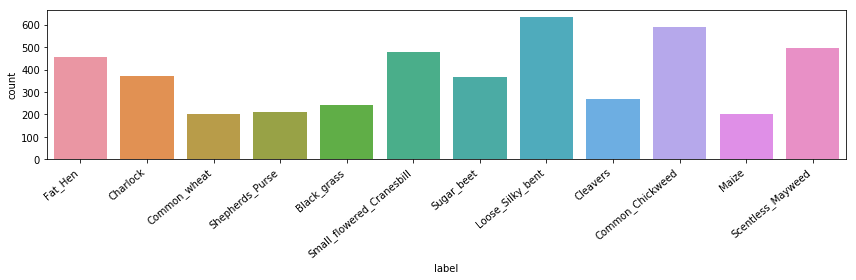

In [7]:
#creating 2 dataframe, one for each dataset slice.
train=[]
test=[]
for cat in categories:
  train_category_path = os.path.join(train_path,cat)
  test_category_path  = os.path.join(test_path,cat)
  train_files = os.listdir(train_category_path)
  test_files = os.listdir(test_category_path)
  for train_file in train_files:
      train_file_path=os.path.join(train_category_path,train_file)
      train.append([cat,train_file_path])
  for test_file in test_files:
      test_file_path=os.path.join(test_category_path,test_file)
      test.append([cat,test_file_path])

train_df=pd.DataFrame(train, columns=['label', 'file_path'])
test_df=pd.DataFrame(test, columns=['label', 'file_path'])

# print(test_df)
plt.figure(figsize=(12,4))
ax = sns.countplot(train_df['label'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


## Dealing with imbalance problems
Tipically the solution would be:

* Do the weighted back propagation, this makes the model learn more from the minority class.

in keras this skill is provided by the flag 'class_weight' in the fit_generator

from the keras doc:

class_weight: 
  Optional dictionary mapping class indices (integers) to a weight (float) value, used for   weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.




```
history = model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    nb_epoch=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples,
    class_weight='auto'
)

```





* reducing the size of the majority class.


* accepting the imbalance. Deep learning can cope with this, it just needs lots more data (the solution to everything, actually).

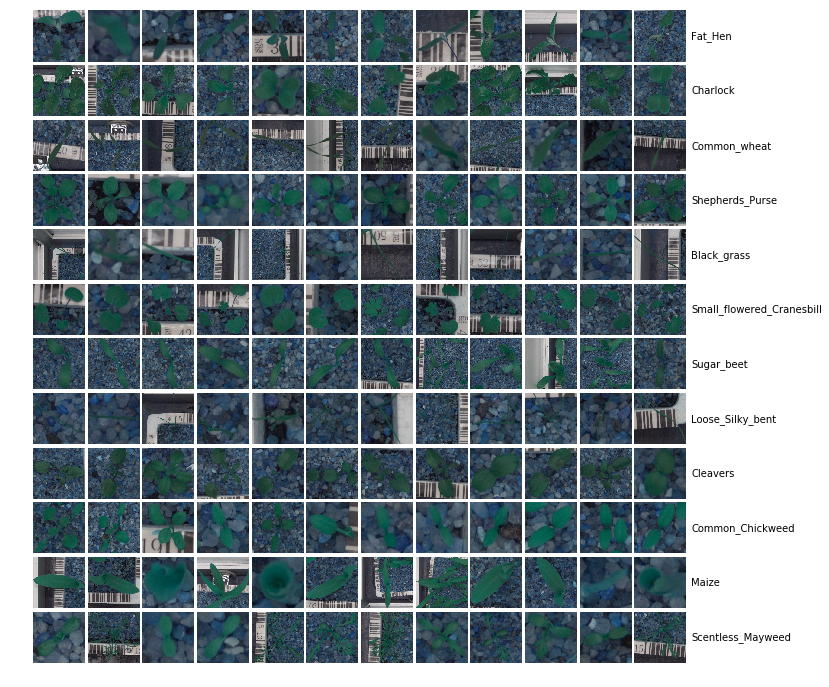

In [8]:
def read_img(filepath,size):
    img = cv2.imread(filepath)
    img = cv2.resize(img,size)
    return img



fig = plt.figure(1, figsize=(n_categories, n_categories))
grid = ImageGrid(fig, 111, nrows_ncols=(n_categories, n_categories), axes_pad=0.05)
i = 0
for category in categories:
    elements = test_df[test_df['label'] == category]['file_path'].values[:n_categories]
    for element in elements:
        filepath = element
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % n_categories == n_categories - 1:
          ax.text(250, 112, filepath.split('/')[-2], verticalalignment='center')
        i += 1       
plt.show();  

# Data ingestion pipeline

![](https://drive.google.com/uc?id=1do0oA8kmdwS12R2flF2_usatEqQlVABG)

In [0]:
def preprocess_input(x):
    x = x/255
    return x
  
def preprocess_input_vgg(x):
        x[ :, :, 0] -= 103.939
        x[ :, :, 1] -= 116.779
        x[ :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[ :, :, ::-1]
  


def imgGeneratorsVgg16(preprocess_input,train_dir,val_dir,img_w,img_h,batch_size,test_batch_size):
  
    train_datagen = ImageDataGenerator(
        preprocessing_function=vgg16preproc,
#         rotation_range=30,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         brightness_range=[0.5, 1.5],
#         horizontal_flip=True

    )

  
    test_datagen = ImageDataGenerator(
        preprocessing_function=vgg16preproc,
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_w, img_h),
        batch_size=batch_size
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=(img_w, img_h),
        batch_size=test_batch_size
    )

    return train_generator, validation_generator
  
def imgGeneratorsNoAugment(preprocess_input,train_dir,val_dir,img_w,img_h,batch_size,test_batch_size):
  
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,

    )

  
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_w, img_h),
        batch_size=batch_size
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=(img_w, img_h),
        batch_size=test_batch_size
    )

    return train_generator, validation_generator
  
def imgGenerators(preprocess_input,train_dir,val_dir,img_w,img_h,batch_size,test_batch_size):
  
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True
    )

  
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        # rotation_range=30,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_w, img_h),
        batch_size=batch_size
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=(img_w, img_h),
        batch_size=test_batch_size
    )

    return train_generator, validation_generator
  

## Visualize some augmented images

Found 4510 images belonging to 12 classes.
Found 240 images belonging to 12 classes.


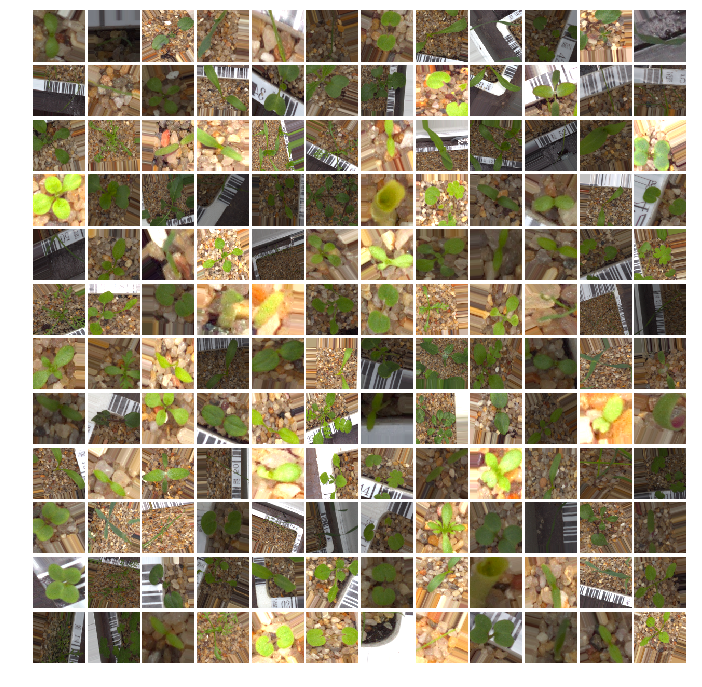

In [10]:
img_width, img_height, img_channels = 100, 100, 3
n_epochs = 3
batch_size = 12*12
test_batch_size = 1
train_generator, test_generator = imgGenerators(preprocess_input,train_path,test_path,img_width,img_height, batch_size,test_batch_size)
x_batch, y_batch = next(train_generator)

fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(12, 12), axes_pad=0.05)

for i in range(0,batch_size):
  image = x_batch[i]*255
  ax = grid[i]
  ax.imshow(image / 255.)
  ax.axis('off')     
plt.show();  

# Create your own NN

![](https://drive.google.com/uc?id=1ayKLrSQwrV7tpKT0Z4aPSWnXY1SUX3UK)



> # Max pooling


![](https://drive.google.com/uc?id=1eqLf7Ytw1Zli0Y9whV0aw9DMIS5ZdjLX)

> # Dropout

![](https://drive.google.com/uc?id=17wonRo5zKrOYcw9ji0yNlReAQYGhR0XC)

In [0]:
def get_simple_model(n_labels,img_w,img_h,img_c,learning_rate,verbose=True):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='glorot_normal', input_shape=(img_w, img_h, img_c)))
  model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
  model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation='relu',kernel_initializer='glorot_normal'))
  model.add(Dropout(0.5))
  model.add(Dense(n_labels, activation='softmax'))

  sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
  if verbose:
    print(model.summary())
  return model

def get_simple_model_zero_init(n_labels,img_w,img_h,img_c,learning_rate,verbose=True):
  model = Sequential()
  model.add(Conv2D(32, (3, 3),kernel_initializer='zeros', activation='relu', input_shape=(img_w, img_h, img_c)))
  model.add(Conv2D(32, (3, 3),kernel_initializer='zeros', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3),kernel_initializer='zeros', activation='relu'))
  model.add(Conv2D(64, (3, 3),kernel_initializer='zeros', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation='relu',kernel_initializer='zeros'))
  model.add(Dropout(0.5))
  model.add(Dense(n_labels, activation='softmax',kernel_initializer='zeros'))

  sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
  if verbose:
    print(model.summary())
  return model

In [18]:
simple_model=get_simple_model(n_categories,100,100,3,0.003)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [17]:
img_width, img_height, img_channels = 100, 100, 3
batch_size = 32
test_batch_size = 32
epochs = 120

train_generator, test_generator =  imgGenerators(preprocess_input,train_path,test_path,img_width,img_height, batch_size,test_batch_size)

nb_train_samples=len(train_df)
nb_test_samples=len(test_df)

train_iterations = (nb_train_samples//batch_size)/10
test_iterations  = nb_test_samples//test_batch_size

print(f"Training the net on {dataset} dataset for {epochs} epochs, {train_iterations} train iterations and {test_iterations} test_iterations ")

Found 4510 images belonging to 12 classes.
Found 240 images belonging to 12 classes.
Training the net on plants dataset for 120 epochs, 14.0 train iterations and 7 test_iterations 


# Model result evaluation
Matplotlib is used again, this time in order to plot the progression epoch after epoch of our model over metrics such as accuracy and loss, handling insight over the training progress, allowing its evaluation.

One of the most important  concepts that shall be taken into account is about overfitting.
This means that our model is adapting way too much to the training set (composed by the observations that are already known) instead of performing well on the test set (new observations).

The most obvious symptom of this is a growing difference in between the training and validation set's metric scores, most usually by the training set still improving over epochs while the validation set is stuck or even gets worse.

Methods such as Data Augmentation and Dropout layers have been used for the model.

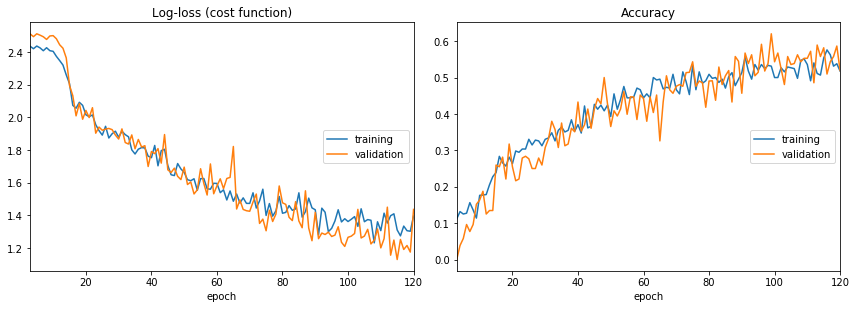

Log-loss (cost function):
training   (min:    1.232, max:    2.477, cur:    1.396)
validation (min:    1.130, max:    2.511, cur:    1.437)

Accuracy:
training   (min:    0.100, max:    0.576, cur:    0.518)
validation (min:    0.000, max:    0.620, cur:    0.519)


In [19]:


simple_model.fit_generator(
    train_generator,
    steps_per_epoch=train_iterations,
    nb_epoch=epochs,
    validation_data=test_generator,
    validation_steps=test_iterations,
    callbacks=[PlotLossesKeras()],
    verbose = 0,
    class_weight='auto'
)


# THE IMPORTANCE OF THE WEIGHTS INITIALIZATION

The previous training is done with a well set NN.

The weighted layers are initialized with
* Glorot normal initializer, also called Xavier normal initializer. It draws samples from a truncated normal distribution
\begin{align} x = 0 \end{align}
\begin{align} stddev =\sqrt{\frac{2}{inSize + outSize} }\end{align}
http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf


In [18]:
simple_model_zeros=get_simple_model_zero_init(n_categories,100,100,3,0.003,verbose=False)
img_width, img_height, img_channels = 100, 100, 3
batch_size = 32
test_batch_size = 32
epochs = 30

train_generator, test_generator =  imgGenerators(preprocess_input,train_path,test_path,img_width,img_height, batch_size,test_batch_size)

nb_train_samples=len(train_df)
nb_test_samples=len(test_df)

train_iterations = (nb_train_samples//batch_size)/10
test_iterations  = nb_test_samples//test_batch_size

print(f"Training the net on {dataset} dataset for {epochs} epochs, {train_iterations} train iterations and {test_iterations} test_iterations ")




Found 4510 images belonging to 12 classes.
Found 240 images belonging to 12 classes.
Training the net on plants dataset for 60 epochs, 14.0 train iterations and 7 test_iterations 


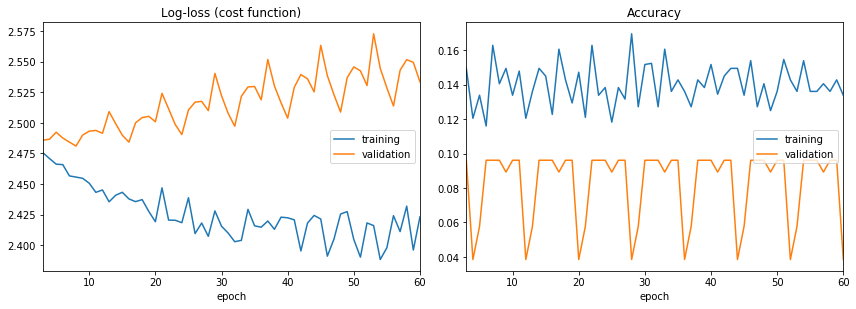

Log-loss (cost function):
training   (min:    2.388, max:    2.484, cur:    2.423)
validation (min:    2.481, max:    2.573, cur:    2.533)

Accuracy:
training   (min:    0.116, max:    0.170, cur:    0.134)
validation (min:    0.038, max:    0.096, cur:    0.038)


In [19]:
simple_model_zeros.fit_generator(
    train_generator,
    steps_per_epoch=train_iterations,
    nb_epoch=epochs,
    validation_data=test_generator,
    validation_steps=test_iterations,
    callbacks=[PlotLossesKeras()],
    verbose = 0,
    class_weight='auto'
)

#What is Confusion Matrix and why you need it?

Well, it is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

### True Positive:
* The NN prediction is positive and it’s true.

###  True Negative:
* The NN prediction is negative and it’s true.

### False Positive:
* The NN prediction is positive and it’s false.

###  False Negative: 
* The NN prediction is negative and it’s false.

These values are now used to compute some important metrics in order to demonstrate the goodness of the training:

### Recall
* Out of all the positive classes, how much we predicted correctly. It should be high as possible.
\begin{align} Recall =\frac{True\: positives}{True\: positives + False\: negatives} \end{align}

### Precision
* Out of all the classes, how much we predicted correctly. It should be high as possible.
\begin{align} Precision =\frac{True\: positives}{True\: positives + True\: negatives} \end{align}

### F1-Score
\begin{align} F1 =\frac{2*Recall*Precision}{Recall + Precision} \end{align}


It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use F-Score. F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

Found 4510 images belonging to 12 classes.
Found 240 images belonging to 12 classes.
                           precision    recall  f1-score   support

              Black_grass       0.50      0.10      0.17        20
                 Charlock       0.38      0.90      0.53        20
                 Cleavers       0.55      0.90      0.68        20
         Common_Chickweed       1.00      0.55      0.71        20
             Common_wheat       0.67      0.10      0.17        20
                  Fat_Hen       0.56      0.50      0.53        20
         Loose_Silky_bent       0.43      0.95      0.59        20
                    Maize       0.78      0.35      0.48        20
        Scentless_Mayweed       0.24      0.25      0.24        20
          Shepherds_Purse       0.80      0.20      0.32        20
Small_flowered_Cranesbill       0.55      0.80      0.65        20
               Sugar_beet       0.53      0.40      0.46        20

                 accuracy                 

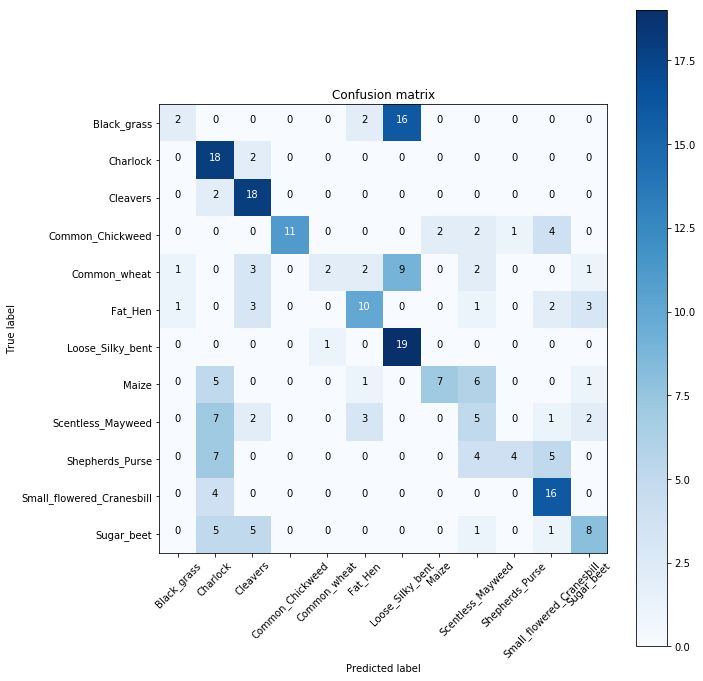

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

batch_size=1
# nb_val_samples = 
train_generator, validation_generator = imgGenerators(preprocess_input,train_path,test_path,img_width,img_height,batch_size,batch_size)
#Confution Matrix and Classification Report
Y_pred = simple_model.predict_generator(validation_generator, nb_test_samples)
y_pred = np.argmax(Y_pred, axis=1)



# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix(validation_generator.classes, y_pred), classes = validation_generator.class_indices.keys()) 

# print('Classification Report')
target_names = validation_generator.class_indices.keys()
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.

* Reduce the network’s capacity by removing layers or reducing the number of elements in the hidden layers
* Apply regularization, which comes down to adding a cost to the loss function for large weights
* Use Dropout layers, which will randomly remove certain features by setting them to zero

In [0]:
dataset_overfitting="plants_overfitting"
dataset_path_overfitting=os.path.join("data",dataset_overfitting)
train_path_overfitting=os.path.join(dataset_path_overfitting,"train")
test_path_overfitting=os.path.join(dataset_path_overfitting,"test")
categories_overfitting=os.listdir(train_path_overfitting)
n_categories_overfitting=len(categories_overfitting)

In [0]:
#creating 2 dataframe, one for each dataset slice.
train_overfitting=[]
test_overfitting=[]
for cat in categories_overfitting:
  train_category_path_overfitting = os.path.join(train_path_overfitting,cat)
  test_category_path_overfitting  = os.path.join(test_path_overfitting,cat)
  train_files_overfitting = os.listdir(train_category_path_overfitting)
  test_files_overfitting = os.listdir(test_category_path_overfitting)
  for train_file_overfitting in train_files_overfitting:
      train_file_path_overfitting=os.path.join(train_category_path_overfitting,train_file_overfitting)
      train.append([cat,train_file_path_overfitting])
  for test_file_overfitting in test_files_overfitting:
      test_file_path_overfitting=os.path.join(test_category_path_overfitting,test_file_overfitting)
      test.append([cat,test_file_path_overfitting])

train_df_overfitting=pd.DataFrame(train_overfitting, columns=['label', 'file_path'])
test_df_overfitting=pd.DataFrame(test_overfitting, columns=['label', 'file_path'])

In [23]:
img_width, img_height, img_channels = 100, 100, 3
batch_size_overfitting = 12
test_batch_size_overfitting = 12
epochs = 60

train_generator_overfitting, test_generator_overfitting =  imgGeneratorsNoAugment(preprocess_input,train_path_overfitting,test_path_overfitting,img_width,img_height, batch_size_overfitting,test_batch_size_overfitting)

nb_train_samples_overfitting=len(train_df_overfitting)
nb_test_samples_overfitting=len(test_df_overfitting)

train_iterations_overfitting = int((nb_train_samples/batch_size_overfitting)/10)
test_iterations_overfitting  = int((nb_test_samples/test_batch_size_overfitting))

print(f"Training the net on {dataset} dataset for {epochs} epochs, {train_iterations_overfitting} train iterations and {test_iterations_overfitting} test_iterations ")

Found 600 images belonging to 12 classes.
Found 60 images belonging to 12 classes.
Training the net on plants dataset for 60 epochs, 37 train iterations and 20 test_iterations 


In [24]:
simple_model_overfitting=get_simple_model(n_categories_overfitting,100,100,3,0.003)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
__________

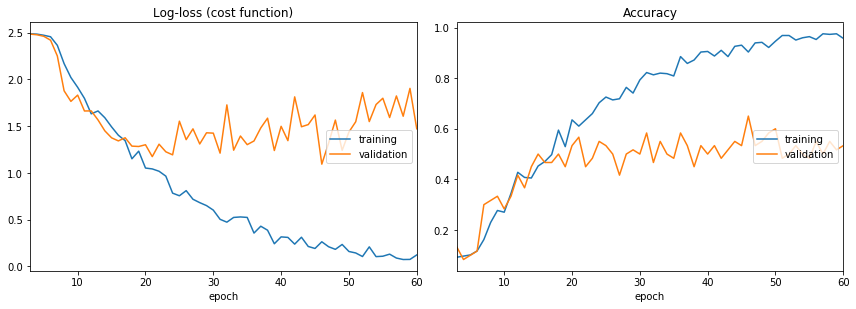

Log-loss (cost function):
training   (min:    0.074, max:    2.490, cur:    0.123)
validation (min:    1.093, max:    2.484, cur:    1.471)

Accuracy:
training   (min:    0.081, max:    0.975, cur:    0.957)
validation (min:    0.083, max:    0.650, cur:    0.533)


In [25]:
simple_model_overfitting.fit_generator(
    train_generator_overfitting,
    steps_per_epoch=train_iterations_overfitting,
    nb_epoch=epochs,
    validation_data=test_generator_overfitting,
    validation_steps=test_iterations_overfitting,
    callbacks=[PlotLossesKeras()],
    verbose = 0,
    class_weight='auto'
)


# Using pre-trained NN: bottleneck features

In [26]:
pretrained = vgg16.VGG16(weights='imagenet', include_top=True,input_shape = (224,224,3))
for layer in pretrained.layers:
    layer.trainable = False
pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
x = pretrained.layers[-2].output
# x = Flatten(input_shape=pretrained.output_shape[1:])(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)
newmodel = Model(input=pretrained.input, output=predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [28]:
  sgd = SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
  newmodel.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
  print(newmodel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

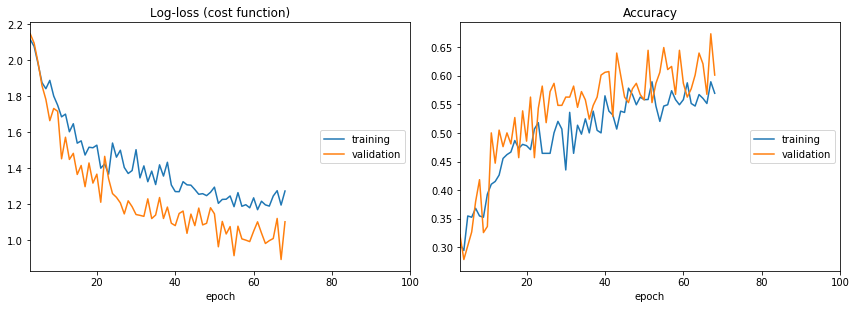

Log-loss (cost function):
training   (min:    1.168, max:    2.871, cur:    1.272)
validation (min:    0.891, max:    2.406, cur:    1.101)

Accuracy:
training   (min:    0.165, max:    0.589, cur:    0.569)
validation (min:    0.232, max:    0.673, cur:    0.601)


In [0]:
batch_size=32
train_generator_vgg, validation_generator_vgg = imgGeneratorsVgg16(preprocess_input,train_path,test_path,224,224, batch_size,batch_size)

nb_train_samples=len(train_df)
nb_val_samples=len(test_df)

epochs=100

history = newmodel.fit_generator(
    train_generator_vgg,
    steps_per_epoch=((nb_train_samples//batch_size)/10),
    nb_epoch=epochs,
    validation_data=validation_generator_vgg,
    validation_steps=nb_val_samples//batch_size,
    callbacks=[PlotLossesKeras()],
    verbose = 0
)


In [0]:
batch_size=1
# nb_val_samples = 
train_generator, validation_generator = imgGeneratorsVgg16(preprocess_input,train_path,test_path,224,224,batch_size,batch_size)
#Confution Matrix and Classification Report
Y_pred = newmodel.predict_generator(validation_generator, nb_test_samples)
y_pred = np.argmax(Y_pred, axis=1)



# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix(validation_generator.classes, y_pred), classes = validation_generator.class_indices.keys()) 

# print('Classification Report')
target_names = validation_generator.class_indices.keys()
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

#Convolutional NN filters visualization
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [0]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
#         print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
#                                                                   loss_value,
#                                                                   e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        plt.figure(figsize=(10,10))
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
#         cv2.imshow(stitched_filters)
#         save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)
        imshow(np.asarray(stitched_filters))

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)
    

#### First layer of the Simple net

Compute filters 0 to 32
11 filter processed.


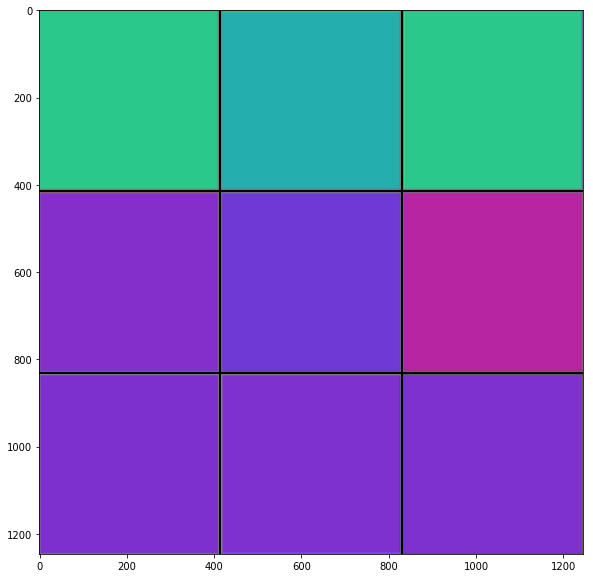

In [31]:
visualize_layer(simple_model, simple_model.layers[1].name)

#### Deepest Conv layer of the Simple net

Compute filters 0 to 64
15 filter processed.


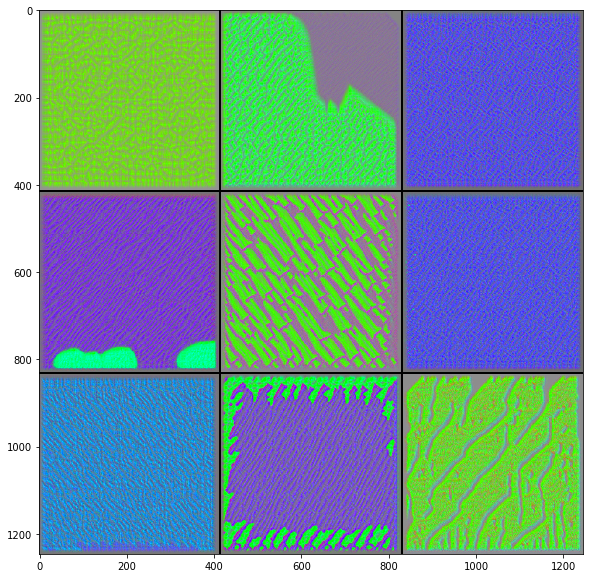

In [32]:
visualize_layer(simple_model, simple_model.layers[5].name)

#### Deepest Conv layer of the Simple net with random weights

In [0]:
raw_model = get_simple_model(12,100,100,3,0.003,verbose=False)

Compute filters 0 to 64
37 filter processed.


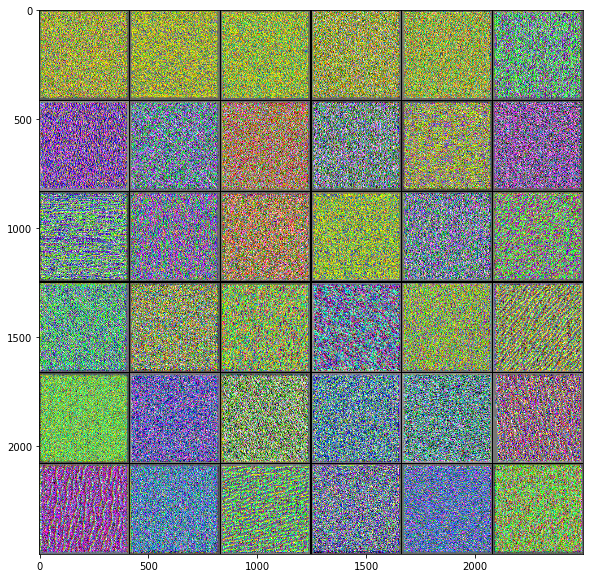

In [34]:
visualize_layer(raw_model, raw_model.layers[5].name)

#### Vgg16 pretrained on imagenet

In [36]:
vgg = vgg16.VGG16(weights='imagenet', include_top=False)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### Deepest Conv layer of Vgg16 pretrained on imagenet

Compute filters 0 to 30
1 filter processed.


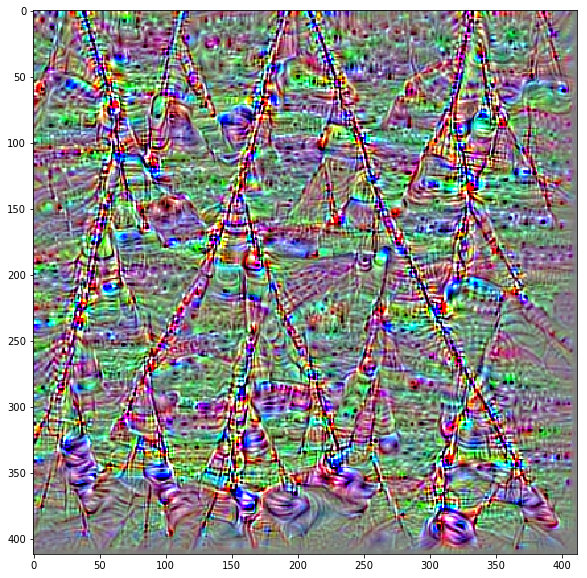

In [37]:

LAYER_NAME = 'block5_conv3'
visualize_layer(vgg, LAYER_NAME,filter_range=(0,30))

#### Middle Conv layer of Vgg16 pretrained on imagenet

Compute filters 0 to 6
6 filter processed.


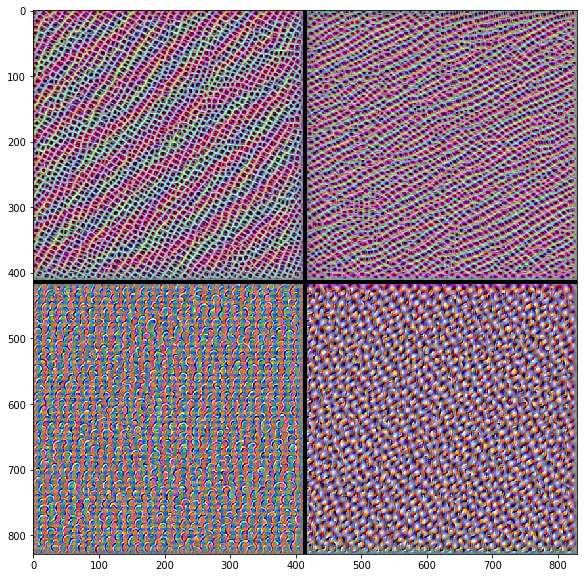

In [38]:
LAYER_NAME = 'block3_conv2'
visualize_layer(vgg, LAYER_NAME,filter_range=(0,6))

![](https://drive.google.com/uc?id=1BuKzW17i-AoCxWFUqQc2OvxWNGaAwkZs)